In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
from numpy import arange
from datetime import timedelta
from dateutil import parser
from pandasql import sqldf
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import numpy as np
import warnings
import pandas as pd

# Allow to display all dataframes columns
pd.set_option("display.max_columns", None)

# Inactivate warnings
warnings.filterwarnings('ignore')

# Creation of files for the study of temporal stability

## Loading revised data

In [3]:
orders = pd.read_csv('olist_orders_reviewed.csv', sep=',', decimal='.',
                     encoding='utf8', low_memory=False)
print(orders.shape)

(114851, 45)


## Feature engineering

In [4]:
orders['order_purchase_timestamp'] = pd.to_datetime(
    orders.order_purchase_timestamp)
orders['order_purchase_timestamp'] = orders['order_purchase_timestamp'].dt.strftime(
    '%Y-%m-%d')

orders['order_delivered_customer_date'] = pd.to_datetime(
    orders.order_delivered_customer_date)
orders['order_delivered_customer_date'] = orders['order_delivered_customer_date'].dt.strftime(
    '%Y-%m-%d')

orders['order_estimated_delivery_date'] = pd.to_datetime(
    orders.order_estimated_delivery_date)
orders['order_estimated_delivery_date'] = orders['order_estimated_delivery_date'].dt.strftime(
    '%Y-%m-%d')

orders['review_creation_date'] = pd.to_datetime(orders.review_creation_date)
orders['review_creation_date'] = orders['review_creation_date'].dt.strftime(
    '%Y-%m-%d')

orders['review_answer_timestamp'] = pd.to_datetime(
    orders.review_answer_timestamp)
orders['review_answer_timestamp'] = orders['review_answer_timestamp'].dt.strftime(
    '%Y-%m-%d')

In [5]:
max_command_date = parser.parse(orders['order_purchase_timestamp'].max())
max_command_date

datetime.datetime(2018, 8, 29, 0, 0)

In [6]:
def last_order_since(df):
    last_command_date = parser.parse(df['order_purchase_timestamp'])
    return (max_command_date-last_command_date).days

In [7]:
def delivery_delay(df):
    dd = parser.parse(df['order_delivered_customer_date'])
    edd = parser.parse(df['order_estimated_delivery_date'])
    return (dd-edd).days

In [8]:
orders.review_comment_message = orders.review_comment_message.fillna('')

In [9]:
def count_review_char(df):
    return len(df['review_comment_message'])

In [10]:
def review_answer_delay(df):
    rcd = parser.parse(df['review_creation_date'])
    rad = parser.parse(df['review_answer_timestamp'])
    return (rad-rcd).days

In [11]:
orders.product_name_lenght = orders.product_name_lenght.fillna(0)
orders.product_description_lenght = orders.product_description_lenght.fillna(0)
orders.product_photos_qty = orders.product_photos_qty.fillna(0)

In [12]:
def desc_detail(df):
    return (df['product_name_lenght'] + df['product_description_lenght'])

## GroupBy

In [13]:
# pandasql helper function
def pysqldf(q): return sqldf(q, globals())

## Baseline sur 1 an

In [14]:
print(orders['order_purchase_timestamp'].min())
print(orders['order_purchase_timestamp'].max())

2016-10-03
2018-08-29


In [15]:
# Define data filters
start_date = orders['order_purchase_timestamp'].min()
end_date = parser.parse(start_date) + timedelta(days=365)
end_date = str(end_date)

after_start_date = orders["order_purchase_timestamp"] >= start_date
before_end_date = orders["order_purchase_timestamp"] <= end_date
between_two_dates = after_start_date & before_end_date

# Apply filters
orders_baseline = orders.loc[between_two_dates]
print('Baseline start date', orders_baseline['order_purchase_timestamp'].min())
print('Baseline end date', orders_baseline['order_purchase_timestamp'].max())
print(orders_baseline.shape)

# Feature ingineering
orders_baseline['last_order_since'] = orders_baseline.apply(
    last_order_since, axis=1)
orders_baseline['delivery_delay'] = orders_baseline.apply(
    delivery_delay, axis=1)
orders_baseline['review_length'] = orders_baseline.apply(
    count_review_char, axis=1)
orders_baseline['review_answer_delay'] = orders_baseline.apply(
    review_answer_delay, axis=1)
orders_baseline['desc_detail'] = orders_baseline.apply(desc_detail, axis=1)
print('Feature engineering done...')

# GroupBy
query = """
SELECT 
    DISTINCT(customer_unique_id) AS customer_id,
    COUNT(DISTINCT(order_id)) AS total_orders,
    COUNT(DISTINCT(product_id)) AS total_products,
    COUNT(DISTINCT(payment_type)) AS total_payment_types,
    COUNT(payment_installments) AS total_payment_installments,
    AVG(last_order_since) AS recency,
    SUM(payment_value) AS total_value,
    AVG(review_score) AS mean_review_score,
    AVG(delivery_delay) AS mean_delivery_delay,
    AVG(review_length) AS mean_review_message_length,
    AVG(review_answer_delay) AS mean_review_answer_delay,
    AVG(desc_detail) AS mean_product_desc_length,
    AVG(product_photos_qty) AS mean_product_photos_qty
FROM orders_baseline
WHERE customer_unique_id IS NOT NULL 
GROUP BY customer_unique_id
ORDER BY customer_unique_id
"""
orders_baseline = pysqldf(query)
print('GroupBy done...')

# Define client list
liste_clients = orders_baseline.customer_id.unique()
print('Clients list done...')

# Drop column
orders_baseline = orders_baseline.drop('customer_id', axis=1)
print('Drop column done...')
print(orders_baseline.shape)

# Save
orders_baseline.to_csv('olist_orders_baseline.csv',
                       sep=',', decimal='.',
                       encoding='utf8', index=False)
print('Saved as ', 'olist_orders_baseline.csv')

Baseline start date 2016-10-03
Baseline end date 2017-10-03
(32344, 45)
Feature engineering done...
GroupBy done...
Clients list done...
Drop column done...
(25916, 12)
Saved as  olist_orders_baseline.csv


## Baseline + x times 30 days

In [16]:
for days in arange(30, 360, 30):
    # Define data filters
    end_date = parser.parse(end_date) + timedelta(days=30)
    end_date = str(end_date)
    print('start date', orders['order_purchase_timestamp'].min())
    print('end date', end_date)
    before_end_date = orders["order_purchase_timestamp"] <= end_date
    filters = after_start_date & before_end_date

    # Apply filters
    orders_ = orders.loc[filters]
    print(orders_.shape)

    # Feature ingineering
    orders_['last_order_since'] = orders_.apply(last_order_since, axis=1)
    orders_['delivery_delay'] = orders_.apply(delivery_delay, axis=1)
    orders_['review_length'] = orders_.apply(count_review_char, axis=1)
    orders_['review_answer_delay'] = orders_.apply(review_answer_delay, axis=1)
    orders_['desc_detail'] = orders_.apply(desc_detail, axis=1)
    print('Feature engineering done...')

    # GroupBy
    query = """
    SELECT 
        DISTINCT(customer_unique_id) AS customer_id,
        COUNT(DISTINCT(order_id)) AS total_orders,
        COUNT(DISTINCT(product_id)) AS total_products,
        COUNT(DISTINCT(payment_type)) AS total_payment_types,
        COUNT(payment_installments) AS total_payment_installments,
        AVG(last_order_since) AS recency,
        SUM(payment_value) AS total_value,
        AVG(review_score) AS mean_review_score,
        AVG(delivery_delay) AS mean_delivery_delay,
        AVG(review_length) AS mean_review_message_length,
        AVG(review_answer_delay) AS mean_review_answer_delay,
        AVG(desc_detail) AS mean_product_desc_length,
        AVG(product_photos_qty) AS mean_product_photos_qty
    FROM orders_
    WHERE customer_unique_id IS NOT NULL 
    GROUP BY customer_unique_id
    ORDER BY customer_unique_id
    """
    orders_ = pysqldf(query)
    print('GroupBy done...')

    # Apply filters
    filters = orders_.customer_id.isin(liste_clients)
    orders_ = orders_.loc[filters]
    print('Client filtering done...')
    print(orders_.shape)

    # Drop column
    orders_ = orders_.drop('customer_id', axis=1)
    print('Drop column done...')
    print(orders_.shape)

    # Save
    orders_.to_csv('olist_orders_' + str(days) + '.csv',
                   sep=',', decimal='.',
                   encoding='utf8', index=False)
    print('Saved as ', 'olist_orders_' + str(days) + '.csv')
    print(109*'_')

start date 2016-10-03
end date 2017-11-02 00:00:00
(37521, 45)
Feature engineering done...
GroupBy done...
Client filtering done...
(25916, 13)
Drop column done...
(25916, 12)
Saved as  olist_orders_30.csv
_____________________________________________________________________________________________________________
start date 2016-10-03
end date 2017-12-02 00:00:00
(46631, 45)
Feature engineering done...
GroupBy done...
Client filtering done...
(25916, 13)
Drop column done...
(25916, 12)
Saved as  olist_orders_60.csv
_____________________________________________________________________________________________________________
start date 2016-10-03
end date 2018-01-01 00:00:00
(52556, 45)
Feature engineering done...
GroupBy done...
Client filtering done...
(25916, 13)
Drop column done...
(25916, 12)
Saved as  olist_orders_90.csv
_____________________________________________________________________________________________________________
start date 2016-10-03
end date 2018-01-31 00:00:00
(

# Loading baseline

In [17]:
Baseline = pd.read_csv('olist_orders_baseline.csv', sep=',',
                       decimal='.', encoding='utf8', low_memory=False)
print(Baseline.shape)

(25916, 12)


# Transformer

In [18]:
norm = Normalizer()

In [19]:
Baseline_normalized = norm.fit_transform(Baseline)

# Model

In [20]:
model = KMeans(n_clusters=5, random_state=0)

In [21]:
model.fit_predict(Baseline_normalized)
labels_baseline = model.labels_

# Temporal stability

In [22]:
ari_tab = {}

In [23]:
for days in arange(30, 360, 30):
    # Data load
    data = pd.read_csv('olist_orders_' + str(days) + '.csv', sep=',', decimal='.',
                       encoding='utf8', low_memory=False)
    # Normalization
    data_normalized = norm.fit_transform(data)
    # Clustering
    model.fit_predict(data_normalized)
    labels = model.labels_
    # ARI calculation
    ari = metrics.adjusted_rand_score(labels_baseline, model.labels_)
    ari_tab[days] = ari

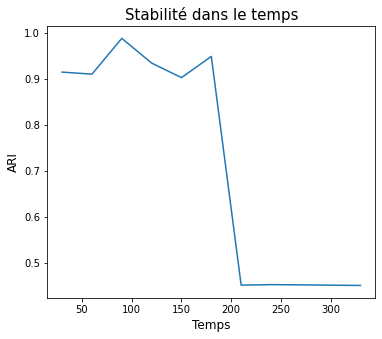

In [24]:
fig = plt.figure(figsize=(20, 5))

ax = fig.add_subplot(1, 3, 1)
ax.plot(list(ari_tab.keys()), list(ari_tab.values()))
ax.set_xlabel('Temps', fontsize=12)
ax.set_ylabel('ARI', fontsize=12)
ax.set_title("Stabilité dans le temps", fontsize=15)
plt.gcf().savefig('time_stability', dpi=100)
plt.show()